# Demonstrate easy xESMF interpolation

### Import modules, functions, and classes

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, xe,
    Path
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from interp_functions import *

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ls

goccp1x1_example.ipynb    xESMF_devel.ipynb
interpolation_test.ipynb  xESMF_testing.ipynb


In [2]:
obs_dir = '/glade/u/home/jonahshaw/w/obs/'

In [4]:
cd '/glade/u/home/jonahshaw/w/obs/'

/glade/work/jonahshaw/obs


In [8]:
ls

CALIPSO/  CLOUDSAT/


In [9]:
cd CALIPSO/GOCCP/2Ddata/grid_1x1_L40/

/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_1x1_L40


In [10]:
ls 2006

MapLowMidHigh330m_200606_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh330m_200607_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh330m_200608_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh330m_200609_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh330m_200610_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh330m_200611_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh330m_200612_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200606_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200607_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200608_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200609_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200610_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200611_avg_CFMIP1_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200612_avg_CFMIP1_sat_3.1.2.nc


### Some of these files fail to open, and others don't

In [3]:
goccp2dpath = '/glade/u/home/jonahshaw/w/obs/CALIPSO/GOCCP/2Ddata/'

In [4]:
try:
    deg1_ds = xr.open_dataset('%s/grid_1x1_L40/2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP1_sat_3.1.2.nc' % goccp2dpath)
    
except ValueError:
    print('Failed')

In [5]:
try:
    deg1_ds = xr.open_dataset('%s/grid_1x1_L40/2010/MapLowMidHigh_Phase330m_201012_avg_CFMIP1_sat_3.1.2.nc' % goccp2dpath)
    
except ValueError:
    print('Failed')

In [6]:
try:
    deg1_ds = xr.open_dataset('%s/grid_1x1_L40/2007/MapLowMidHigh_Phase330m_200712_avg_CFMIP1_sat_3.1.2.nc' % goccp2dpath)
    
except ValueError:
    print('Failed')

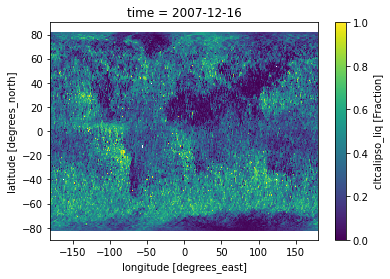

In [7]:
deg1_ds['cltcalipso_liq'].plot()

In [8]:
deg2_ds = xr.open_dataset('%s/grid_2x2_L40/2007/MapLowMidHigh_Phase330m_200712_avg_CFMIP2_sat_3.1.2.nc' % goccp2dpath)

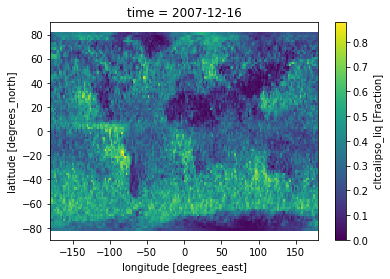

In [9]:
deg2_ds['cltcalipso_liq'].plot()

In [8]:
goccp_dir = '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/'

phase = [] # netCDF files with cloud phase data
cloud = []   # netCDF files with cloud amount data

for year in os.listdir(goccp_dir): # iterate over years (2009-2013)
    _prepath = '%s%s/' % (goccp_dir, year)
    _files = os.listdir(_prepath)

    _phasefiles = [_prepath + x for x in _files if 'Phase' in x]
    _cloudfiles = [_prepath + x for x in _files if 'MapLowMidHigh330m' in x]

    phase = phase + _phasefiles
    cloud = cloud + _cloudfiles
            
phase.sort()
cloud.sort()

_phase_ds = xr.open_mfdataset(phase, combine='by_coords')
_cloud_ds = xr.open_mfdataset(cloud, combine='by_coords')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


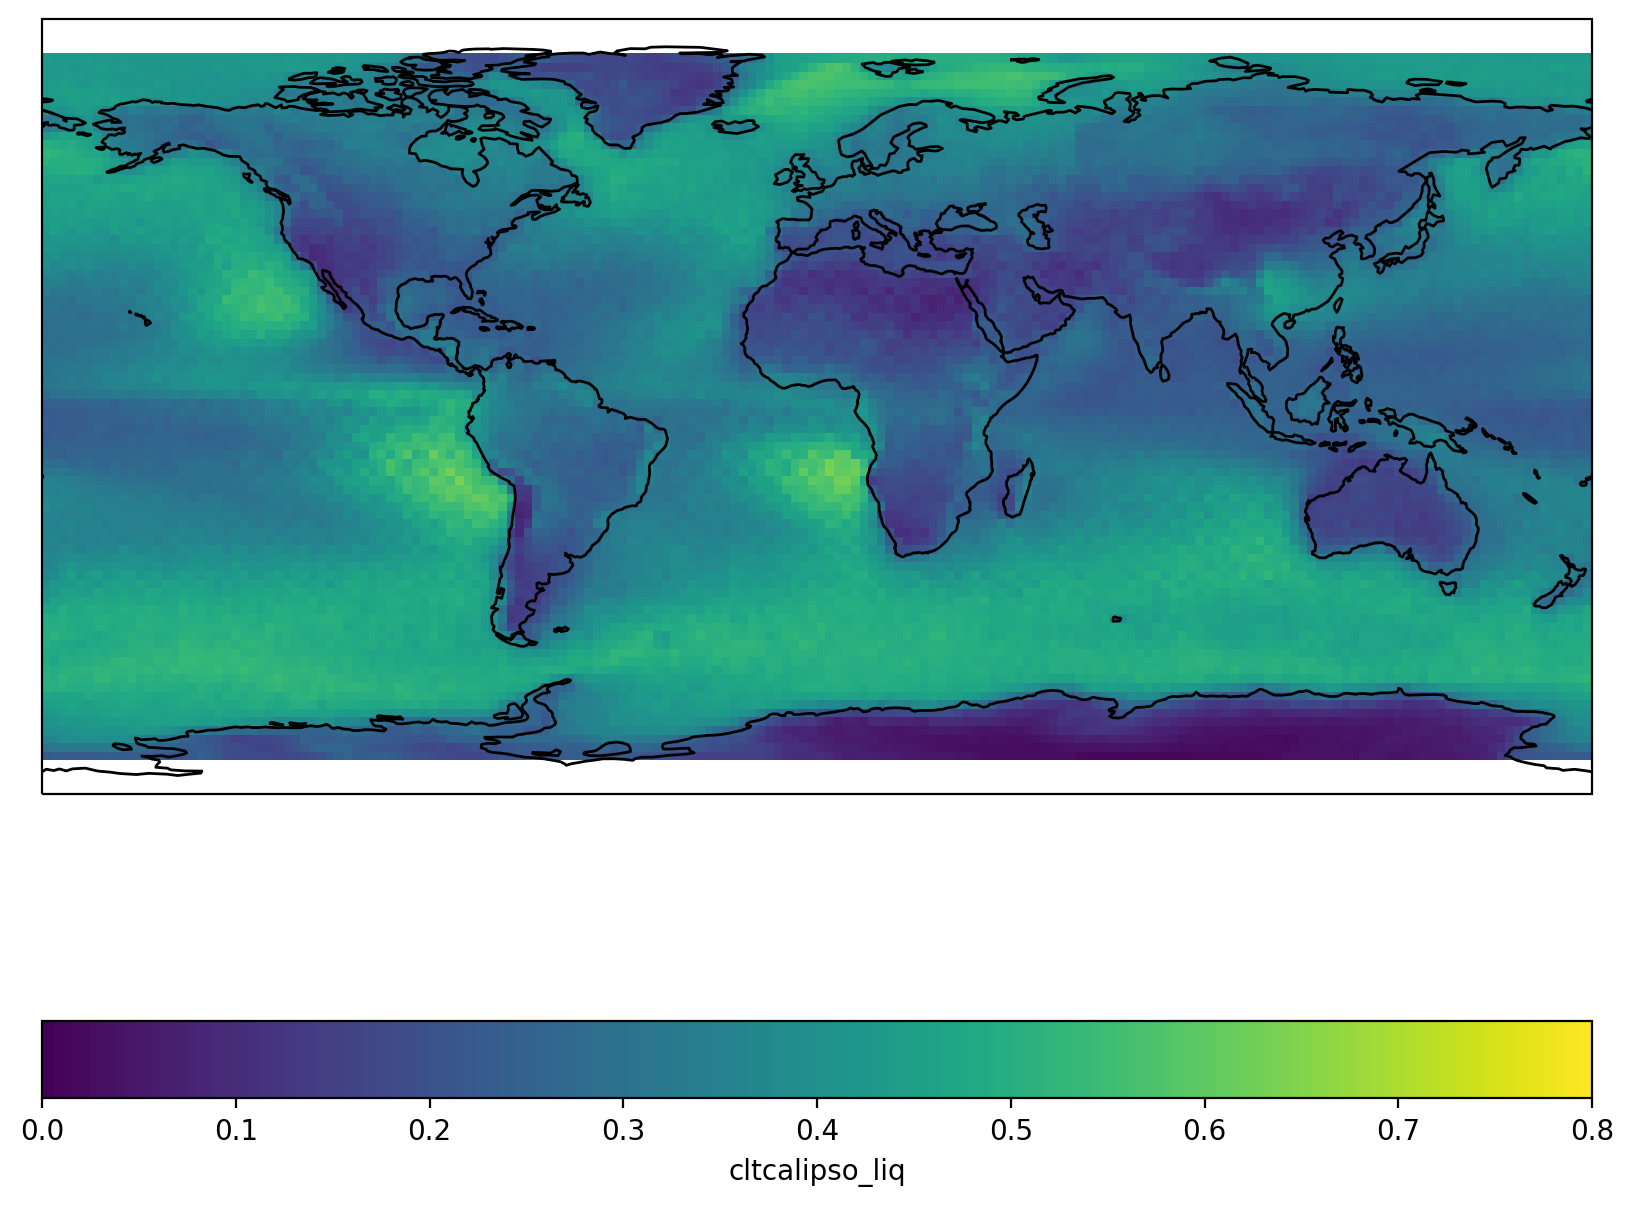

In [9]:
fig = plt.figure(figsize=(10,10),dpi=200)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.coastlines()

_phase_ds['cltcalipso_liq'].mean('time').plot(vmin=0,vmax=0.8, cbar_kwargs={'orientation': 'horizontal'})

In [12]:
to_png(fig,'cltcalipso_liq_2006-2015_2x2')

## Aha!!! It was not an interpolation artifact. It is in the raw data!!!

## Now I will see if these features are present in the 1x1deg data

In [13]:
goccp_dir2 = '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_1x1_L40/'

phase = [] # netCDF files with cloud phase data
cloud = []   # netCDF files with cloud amount data

for year in os.listdir(goccp_dir2): # iterate over years (2009-2013)
    if year != '2006':
        _prepath = '%s%s/' % (goccp_dir2, year)
        _files = os.listdir(_prepath)

        _phasefiles = [_prepath + x for x in _files if 'Phase' in x]
        _cloudfiles = [_prepath + x for x in _files if 'MapLowMidHigh330m' in x]

        phase = phase + _phasefiles
        cloud = cloud + _cloudfiles
            
phase.sort()
cloud.sort()

# for i in cloud:
#     try:
#         xr.open_dataset(i)
#     except ValueError:
#         print(i)

_phase_ds2 = xr.open_mfdataset(phase, combine='by_coords')
_cloud_ds2 = xr.open_mfdataset(cloud, combine='by_coords')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


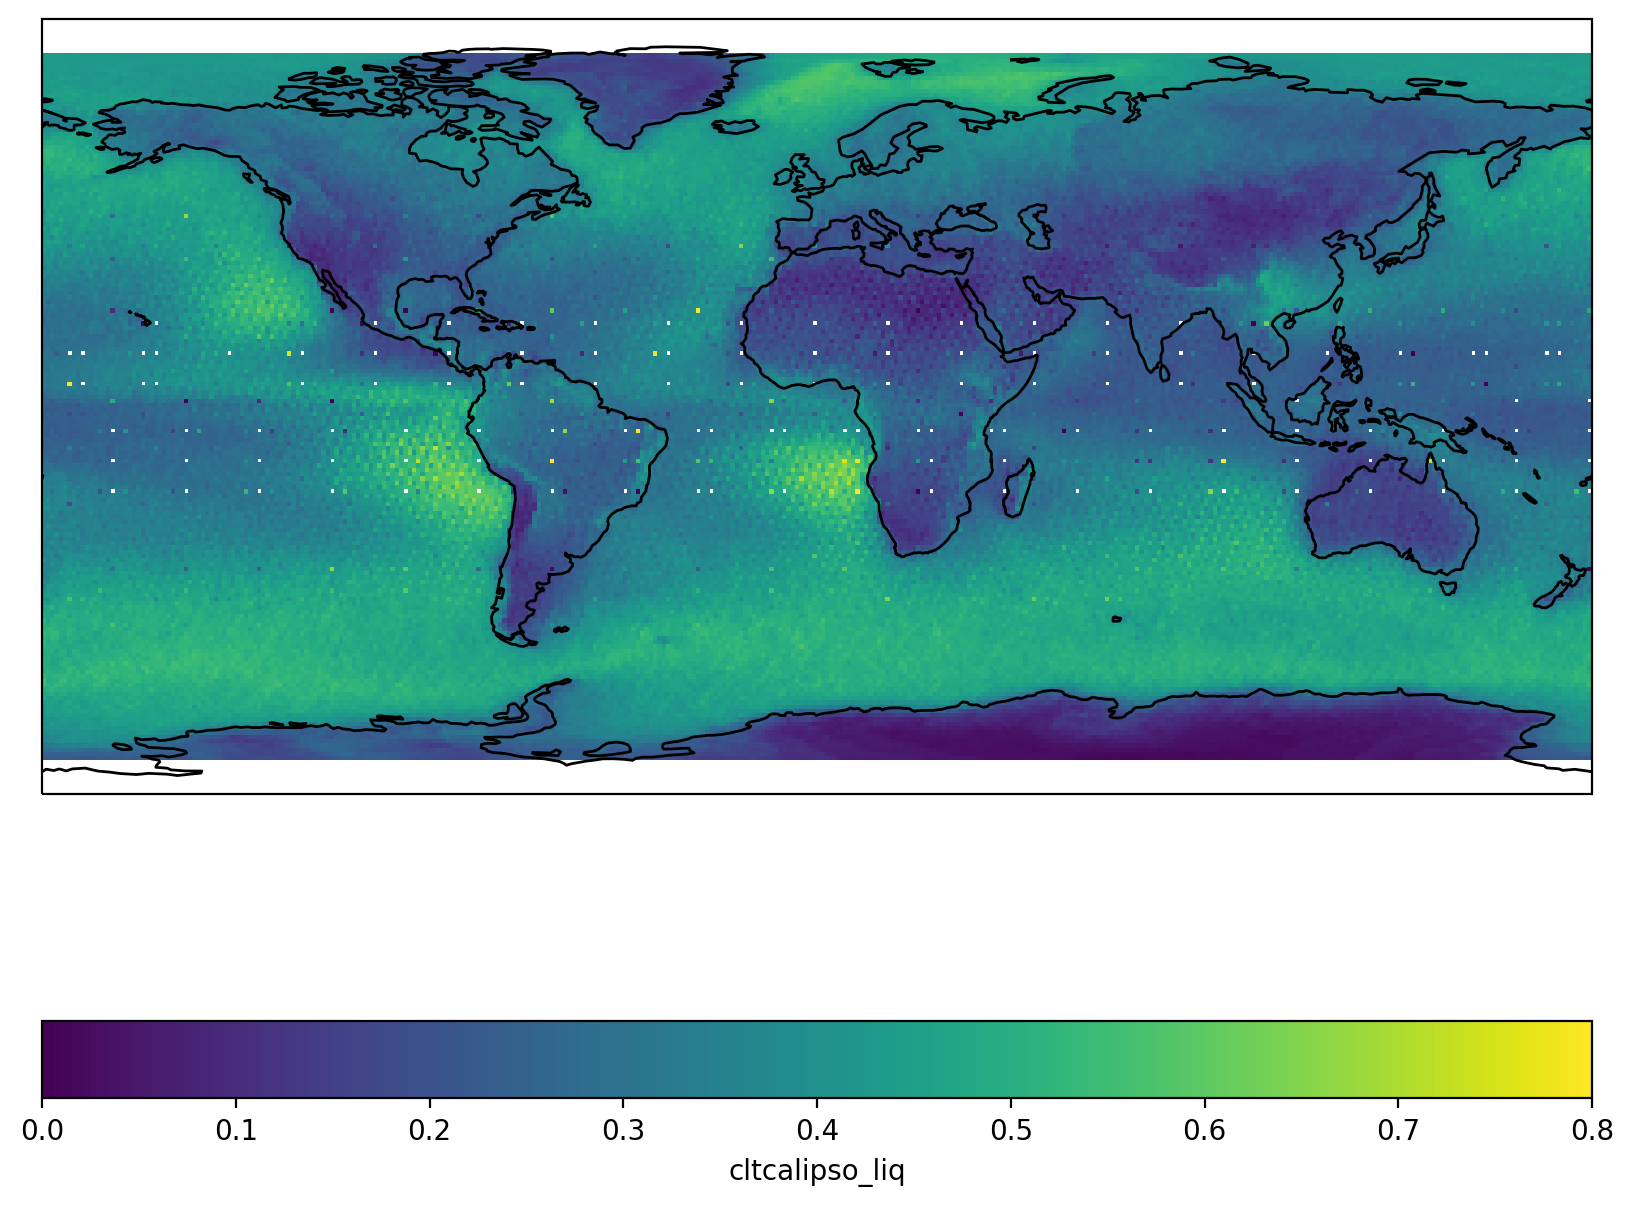

In [14]:
fig = plt.figure(figsize=(10,10),dpi=200)
ax2 = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax2.coastlines()

_phase_ds2['cltcalipso_liq'].mean('time').plot(vmin=0,vmax=0.8,cbar_kwargs={'orientation': 'horizontal','extend':'neither'})

In [15]:
to_png(fig,'cltcalipso_liq_2007-2015_1x1')